In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.datasets import load_basic_motions
from sklearn.model_selection import GridSearchCV, KFold

In [3]:
X_train, y_train = load_basic_motions(split='train', return_type='numpy3D')
X_test, y_test = load_basic_motions(split='test', return_type='numpy3D')

In [5]:
print(X_train.shape)

(40, 6, 100)


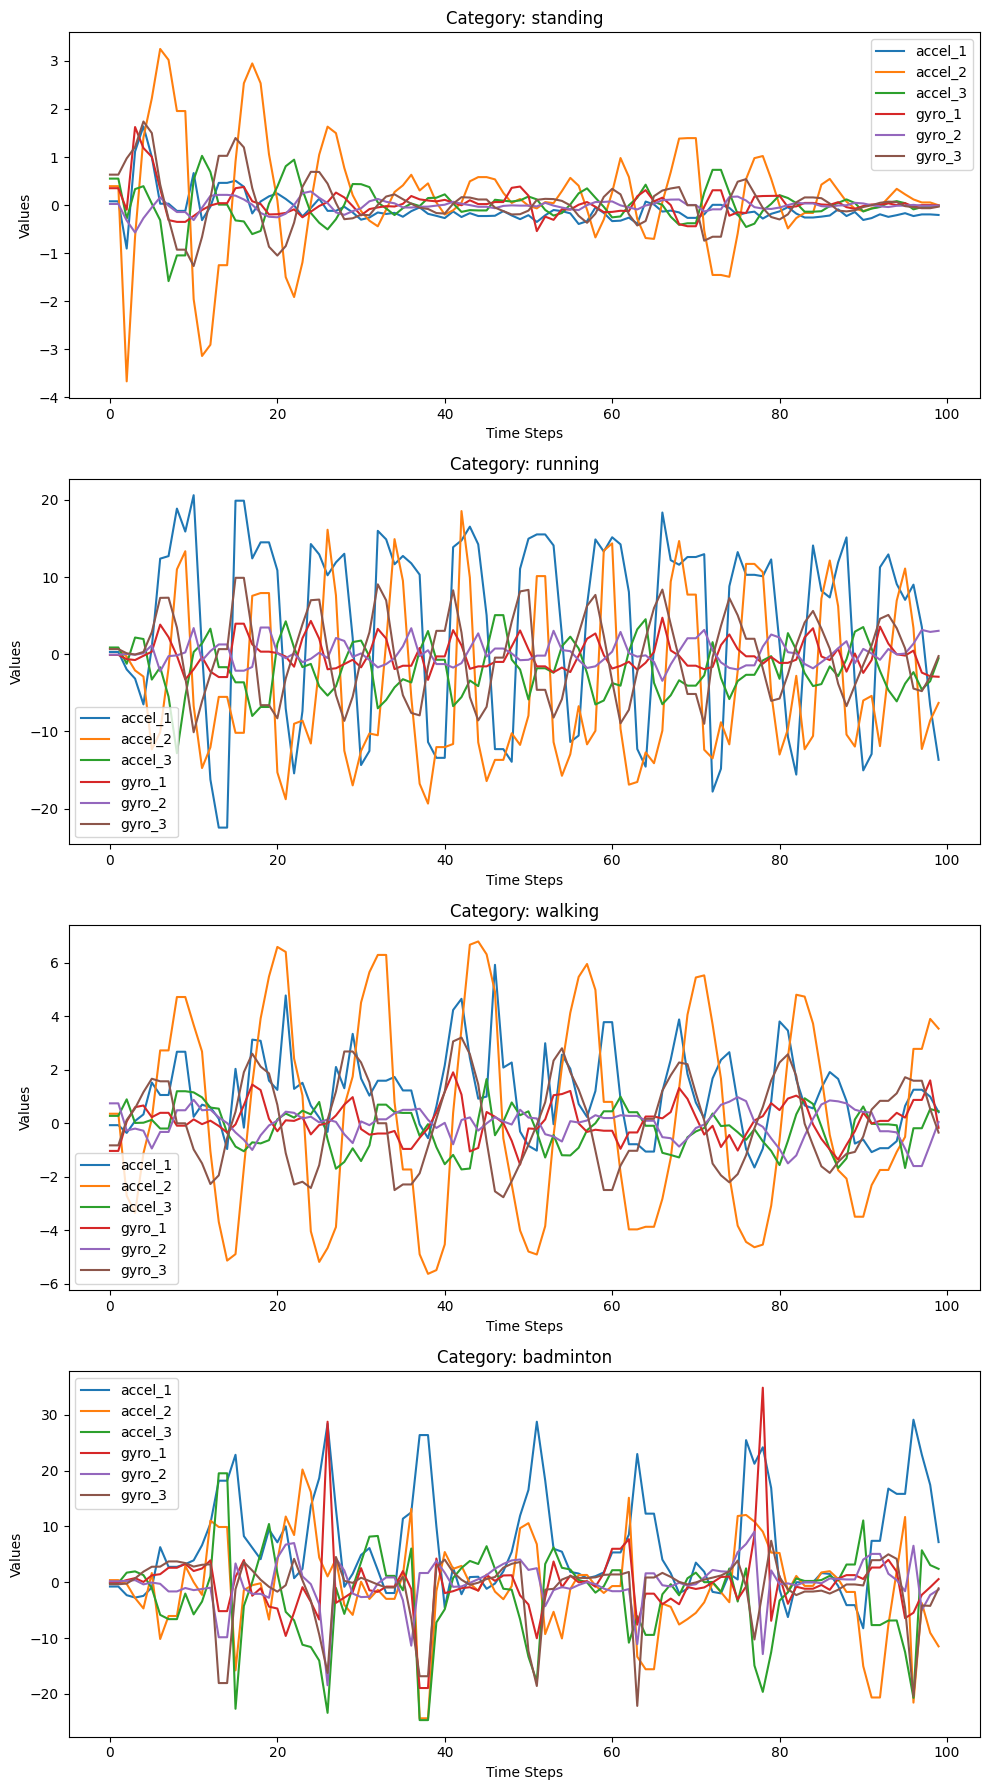

In [4]:
series_indices = [0, 10, 20, 30]
categories = ['standing', 'running', 'walking', 'badminton']
features = ["accel_1", "accel_2", "accel_3", "gyro_1", "gyro_2", "gyro_3"]

selected_series = X_train[series_indices]

fig, axes = plt.subplots(4, 1, figsize=(10, 18))

for i in range(4):  
    for j in range(selected_series.shape[1]):
        axes[i].plot(selected_series[i, j], label=features[j])

    axes[i].set_title(f"Category: {categories[i]}")
    axes[i].set_xlabel("Time Steps")
    axes[i].set_ylabel("Values")
    axes[i].legend()

plt.tight_layout()
plt.show()

## KNN

In [10]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier(n_neighbors=1)

params = {
    "distance": ['euclidean', 'dtw']
}
tuned_knn = GridSearchCV(
    knn, 
    params, 
    cv=KFold(n_splits=5)
)
tuned_knn.fit(X_train, y_train)
y_pred_knn = tuned_clf.predict(X_test)

print(tuned_knn.best_params_)

{'distance': 'dtw'}


## Bagging with WEASEL

In [19]:
from sktime.classification.ensemble import BaggingClassifier
from sktime.classification.dictionary_based import WEASEL
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train)

base_clf = WEASEL(alphabet_size=3,support_probabilities=True, random_state=42)

clf = BaggingClassifier(
    base_clf, 
    n_estimators=6, # there are 6 features in total 
    n_features=1, 
    random_state=42
)
clf.fit(X_train, y_train)
y_pred_bagging = clf.predict(X_test)
y_pred_bagging = encoder.inverse_transform(y_pred_bagging)

## Evaluation

In [24]:
from sklearn.metrics import classification_report, f1_score

knn_report = classification_report(y_test, y_pred_knn, zero_division=0.0)
print(knn_report)

              precision    recall  f1-score   support

   badminton       0.00      0.00      0.00        10
     running       1.00      0.60      0.75        10
    standing       0.48      1.00      0.65        10
     walking       0.62      0.80      0.70        10

    accuracy                           0.60        40
   macro avg       0.52      0.60      0.52        40
weighted avg       0.52      0.60      0.52        40



In [22]:
bagging_report = classification_report(y_test, y_pred_bagging)
print(bagging_report)

              precision    recall  f1-score   support

   badminton       0.91      1.00      0.95        10
     running       1.00      0.80      0.89        10
    standing       0.82      0.90      0.86        10
     walking       1.00      1.00      1.00        10

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40



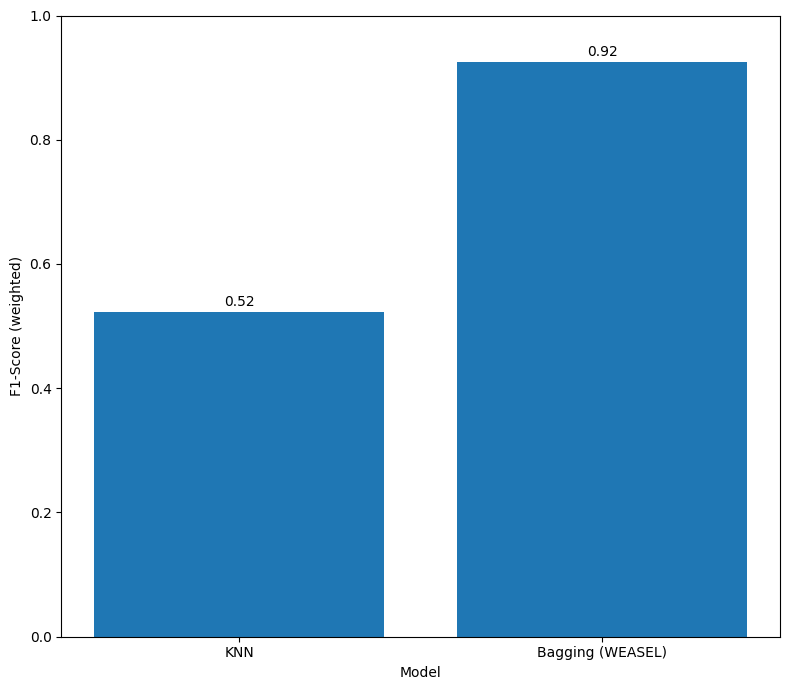

In [28]:
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')
f1_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

x = ['KNN', 'Bagging (WEASEL)']
y = [f1_knn, f1_bagging]

fig, ax = plt.subplots(figsize=(8,7))
ax.bar(x, y)
ax.set_xlabel('Model')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1)

for i, v in enumerate(y):
    ax.text(x=i, y=v+0.01, s=str(round(v,2)), ha='center')

plt.tight_layout()